# Bankroll Simulation

In [39]:
import json
import os
import random
import statistics

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from src import *

TOTAL_SIMULATIONS = 100
SEED = 42
SIMULATION_DIR = "simulations-data"
SIMULATION_NAME = "Month Baccarat"
ESPECIF_SIMULATION_VIEW = 3

## 1. Generate Simulations

In [40]:
if os.path.exists(SIMULATION_DIR):
    print(f"Directory '{SIMULATION_DIR}' already exists. Skipping simulation generation.")
    print(f"Delete the directory to regenerate.")
else:
    os.makedirs(SIMULATION_DIR)
    random.seed(SEED)
    for i in range(TOTAL_SIMULATIONS):
        result = play_simulation(
            "config/simulations", "config/sessions", "config/games", SIMULATION_NAME
        )
        filepath = os.path.join(SIMULATION_DIR, f"{SIMULATION_NAME}_{i}.json")
        with open(filepath, "w") as f:
            json.dump(result, f)
        if (i + 1) % 10000 == 0:
            print(f"Generated {i + 1}/{TOTAL_SIMULATIONS} simulations")
    print(f"Done. All {TOTAL_SIMULATIONS} simulations saved to '{SIMULATION_DIR}/'.")

Directory 'simulations-data' already exists. Skipping simulation generation.
Delete the directory to regenerate.


## 2. Game Expected Values

In [ ]:
from IPython.display import HTML

all_evs = get_all_games_ev("config/games")

TABLE_CSS = """
<style>
.modern-table {
    border-collapse: separate;
    border-spacing: 0;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
    font-size: 13px;
    border-radius: 10px;
    overflow: hidden;
    box-shadow: 0 4px 16px rgba(0,0,0,0.08);
    margin: 8px 0;
}
.modern-table thead th {
    background: linear-gradient(135deg, #1e293b 0%, #334155 100%);
    color: #f1f5f9;
    padding: 10px 16px;
    font-weight: 600;
    letter-spacing: 0.3px;
    border: none;
}
.modern-table tbody td {
    padding: 7px 16px;
    border-bottom: 1px solid #e2e8f0;
    color: #334155;
}
.modern-table tbody tr:last-child td { border-bottom: none; }
.modern-table tbody tr:nth-child(even) { background: #f8fafc; }
.modern-table tbody tr:hover { background: #eef2ff; }
.modern-table .pos { color: #059669; font-weight: 600; }
.modern-table .neg { color: #e11d48; font-weight: 600; }
.modern-table .game-name { font-weight: 600; color: #1e293b; }
.modern-table .section-hdr td {
    background: linear-gradient(135deg, #1e293b 0%, #334155 100%);
    color: #f1f5f9;
    font-weight: 600;
    padding: 8px 16px;
    letter-spacing: 0.3px;
    font-size: 12px;
}
</style>
"""

rows = ""
for game_name, ev_data in all_evs.items():
    if "bet-types" in ev_data:
        first = True
        for bt, ev_val in ev_data["bet-types"].items():
            game_cell = f'<td rowspan="{len(ev_data["bet-types"])}" class="game-name" style="vertical-align:middle;">{ev_data["name"]}</td>' if first else ""
            cls = "pos" if ev_val >= 0 else "neg"
            rows += f'<tr>{game_cell}<td>{bt}</td><td class="{cls}" style="text-align:right;">{ev_val:+.6f}</td></tr>'
            first = False
    else:
        cls = "pos" if ev_data["ev"] >= 0 else "neg"
        rows += f'<tr><td class="game-name">{ev_data["name"]}</td><td style="color:#94a3b8;">—</td><td class="{cls}" style="text-align:right;">{ev_data["ev"]:+.6f}</td></tr>'

HTML(TABLE_CSS + f"""
<table class="modern-table">
<thead>
  <tr>
    <th style="text-align:left;">Game</th>
    <th style="text-align:left;">Bet Type</th>
    <th style="text-align:right;">Expected Value</th>
  </tr>
</thead>
<tbody>{rows}</tbody>
</table>
""")

## 3. Average Simulation Results

In [42]:
# Load all simulations
simulations = []
for i in range(TOTAL_SIMULATIONS):
    filepath = os.path.join(SIMULATION_DIR, f"{SIMULATION_NAME}_{i}.json")
    with open(filepath, "r") as f:
        simulations.append(json.load(f))

print(f"Loaded {len(simulations)} simulations.")

Loaded 100 simulations.


In [43]:
def extract_bankroll_curve(simulation):
    """Extract the bankroll value after each action in a simulation."""
    curve = []
    for action in simulation:
        if action["type"] == "play" and action["bets"]:
            for bet in action["bets"]:
                curve.append(bet["bankroll"])
        else:
            curve.append(action["bankroll"])
    return curve


def get_start_bankroll(simulation):
    """Get the starting bankroll from the first action."""
    first = simulation[0]
    if first["type"] == "play" and first["bets"]:
        return first["bets"][0]["bankroll"] + first["bets"][0]["bet-size"] - first["bets"][0]["payment"]
    return first["bankroll"]


def get_final_bankroll(simulation):
    """Get the final bankroll from the last action."""
    return simulation[-1]["bankroll"]

In [ ]:
start_bankroll = get_start_bankroll(simulations[0])

final_bankrolls = [get_final_bankroll(sim) for sim in simulations]
profits = [fb - start_bankroll for fb in final_bankrolls]

wins = [p for p in profits if p > 0]
losses = [p for p in profits if p < 0]
breakevens = [p for p in profits if p == 0]
bankrupt_count = sum(1 for fb in final_bankrolls if fb <= 0)

min_bankrolls = []
max_bankrolls = []
for sim in simulations:
    curve = extract_bankroll_curve(sim)
    if curve:
        min_bankrolls.append(min(curve))
        max_bankrolls.append(max(curve))

avg_win_str = f"{statistics.mean(wins):+,.2f}" if wins else "N/A"
avg_loss_str = f"{statistics.mean(losses):+,.2f}" if losses else "N/A"

def summary_row(label, value):
    return f'<tr><td style="font-weight:500;">{label}</td><td style="text-align:right;">{value}</td></tr>'

def section_header(text):
    return f'<tr class="section-hdr"><td colspan="2">{text}</td></tr>'

rows = (
    section_header(f"SIMULATION SUMMARY — {TOTAL_SIMULATIONS:,} runs")
    + summary_row("Starting bankroll", f"{start_bankroll:,.2f}")
    + summary_row("Average final bankroll", f"{statistics.mean(final_bankrolls):,.2f}")
    + summary_row("Median final bankroll", f"{statistics.median(final_bankrolls):,.2f}")
    + summary_row("Std dev final bankroll", f"{statistics.stdev(final_bankrolls):,.2f}")
    + section_header("Profit / Loss")
    + summary_row("Average profit", f'<span class="{"pos" if statistics.mean(profits) >= 0 else "neg"}">{statistics.mean(profits):+,.2f}</span>')
    + summary_row("Median profit", f'<span class="{"pos" if statistics.median(profits) >= 0 else "neg"}">{statistics.median(profits):+,.2f}</span>')
    + summary_row("Average win (when > 0)", f'<span class="pos">{avg_win_str}</span>')
    + summary_row("Average loss (when < 0)", f'<span class="neg">{avg_loss_str}</span>')
    + section_header("Outcome Counts")
    + summary_row("Profitable simulations", f'<span class="pos">{len(wins):,} ({100*len(wins)/TOTAL_SIMULATIONS:.2f}%)</span>')
    + summary_row("Losing simulations", f'<span class="neg">{len(losses):,} ({100*len(losses)/TOTAL_SIMULATIONS:.2f}%)</span>')
    + summary_row("Break-even simulations", f"{len(breakevens):,} ({100*len(breakevens)/TOTAL_SIMULATIONS:.2f}%)")
    + summary_row("Bankrupt (bankroll <= 0)", f"{bankrupt_count:,} ({100*bankrupt_count/TOTAL_SIMULATIONS:.2f}%)")
    + section_header("Extremes")
    + summary_row("Min bankroll (overall)", f"{min(min_bankrolls):,.2f}")
    + summary_row("Max bankroll (overall)", f"{max(max_bankrolls):,.2f}")
    + summary_row("Avg min bankroll", f"{statistics.mean(min_bankrolls):,.2f}")
    + summary_row("Avg max bankroll", f"{statistics.mean(max_bankrolls):,.2f}")
    + summary_row("Max profit", f'<span class="pos">{max(profits):+,.2f}</span>')
    + summary_row("Max loss", f'<span class="neg">{min(profits):+,.2f}</span>')
)

HTML(TABLE_CSS + f"""
<table class="modern-table" style="min-width:440px;">
{rows}
</table>
""")

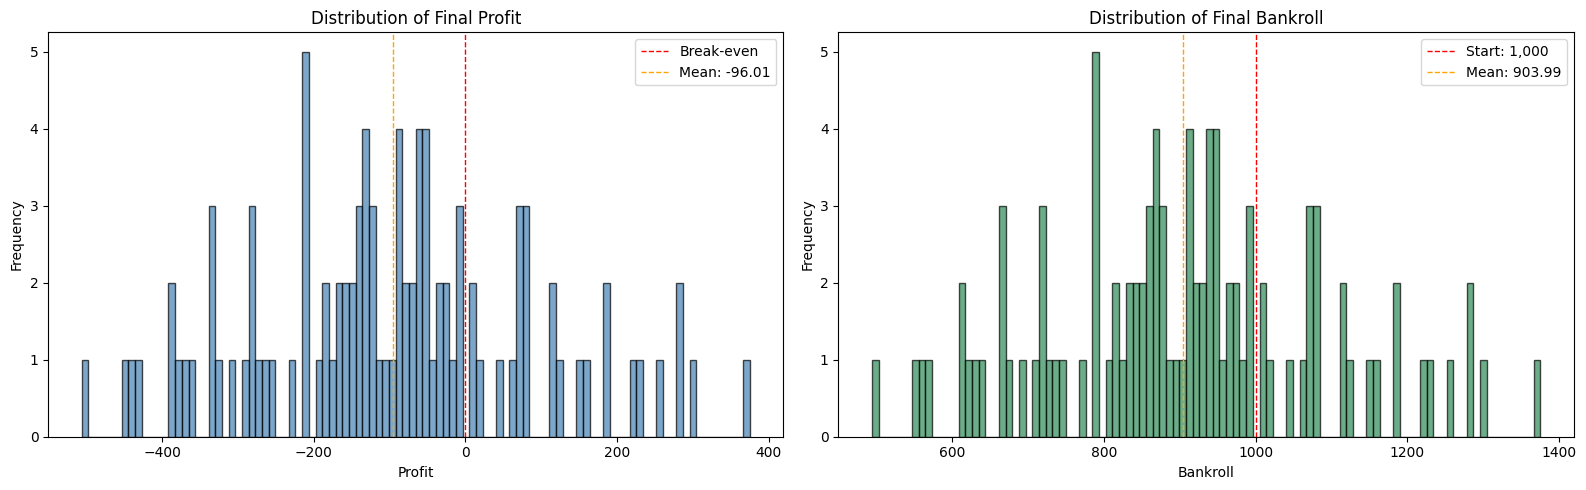

In [45]:
# Distribution of final profits
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(profits, bins=100, edgecolor="black", alpha=0.7, color="steelblue")
axes[0].axvline(0, color="red", linestyle="--", linewidth=1, label="Break-even")
axes[0].axvline(statistics.mean(profits), color="orange", linestyle="--", linewidth=1, label=f"Mean: {statistics.mean(profits):+,.2f}")
axes[0].set_title("Distribution of Final Profit")
axes[0].set_xlabel("Profit")
axes[0].set_ylabel("Frequency")
axes[0].legend()

axes[1].hist(final_bankrolls, bins=100, edgecolor="black", alpha=0.7, color="seagreen")
axes[1].axvline(start_bankroll, color="red", linestyle="--", linewidth=1, label=f"Start: {start_bankroll:,.0f}")
axes[1].axvline(statistics.mean(final_bankrolls), color="orange", linestyle="--", linewidth=1, label=f"Mean: {statistics.mean(final_bankrolls):,.2f}")
axes[1].set_title("Distribution of Final Bankroll")
axes[1].set_xlabel("Bankroll")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

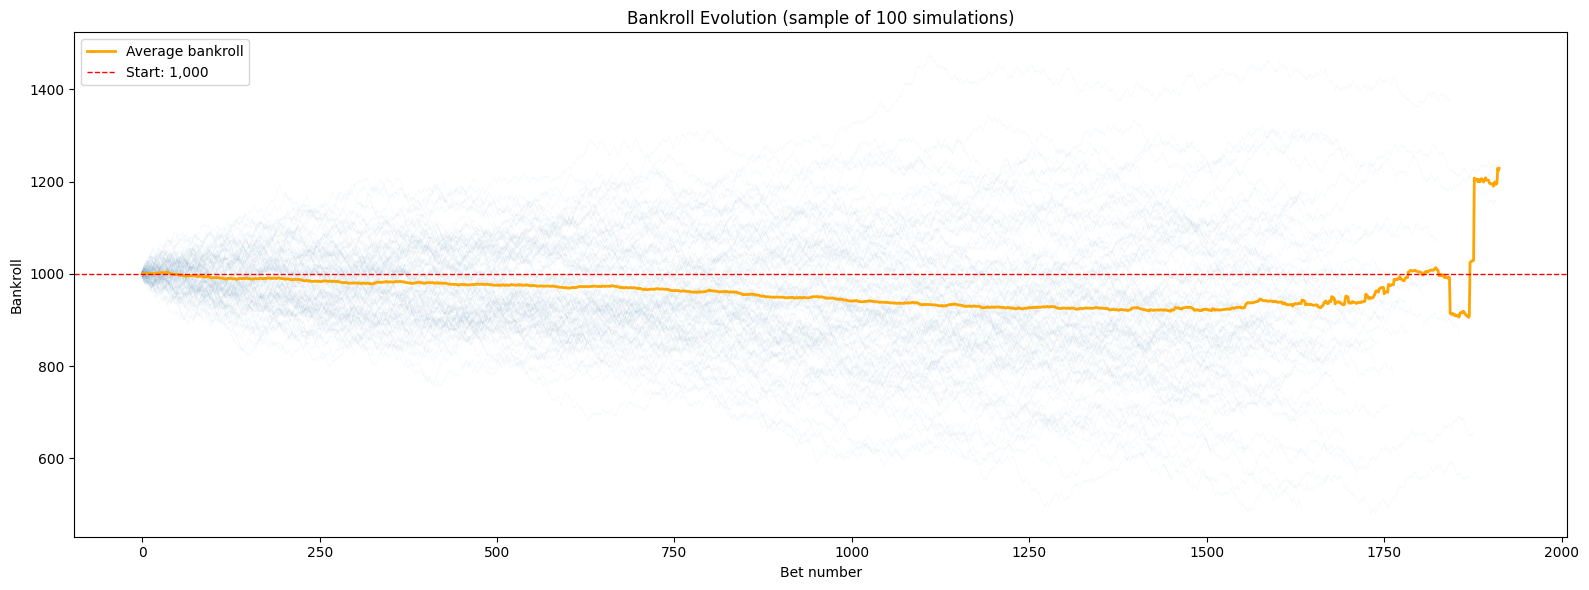

In [46]:
# Bankroll evolution: sample of simulations
SAMPLE_SIZE = 200
sample_indices = random.sample(range(TOTAL_SIMULATIONS), min(SAMPLE_SIZE, TOTAL_SIMULATIONS))

fig, ax = plt.subplots(figsize=(16, 6))
for idx in sample_indices:
    curve = extract_bankroll_curve(simulations[idx])
    ax.plot(curve, alpha=0.05, color="steelblue", linewidth=0.5)

# Compute and plot the average curve
all_curves = [extract_bankroll_curve(sim) for sim in simulations]
max_len = max(len(c) for c in all_curves)
avg_curve = []
for step in range(max_len):
    values = [c[step] for c in all_curves if step < len(c)]
    avg_curve.append(statistics.mean(values))

ax.plot(avg_curve, color="orange", linewidth=2, label="Average bankroll")
ax.axhline(start_bankroll, color="red", linestyle="--", linewidth=1, label=f"Start: {start_bankroll:,.0f}")
ax.set_title(f"Bankroll Evolution (sample of {len(sample_indices)} simulations)")
ax.set_xlabel("Bet number")
ax.set_ylabel("Bankroll")
ax.legend()
plt.tight_layout()
plt.show()

## 4. Key Simulations: Worst, Best, and Average

In [ ]:
worst_idx = profits.index(min(profits))
best_idx = profits.index(max(profits))

# Find simulation closest to the mean profit
mean_profit = statistics.mean(profits)
avg_idx = min(range(TOTAL_SIMULATIONS), key=lambda i: abs(profits[i] - mean_profit))

colors = {"Worst": "#e11d48", "Best": "#059669", "Average": "#6366f1"}
rows = ""
for label, idx in [("Worst", worst_idx), ("Best", best_idx), ("Average", avg_idx)]:
    profit_cls = "pos" if profits[idx] >= 0 else "neg"
    rows += (
        f'<tr>'
        f'<td><span style="display:inline-block; width:8px; height:8px; border-radius:50%; background:{colors[label]}; margin-right:8px;"></span><b>{label}</b></td>'
        f'<td style="text-align:center;">#{idx}</td>'
        f'<td class="{profit_cls}" style="text-align:right;">{profits[idx]:+,.2f}</td>'
        f'<td style="text-align:right;">{final_bankrolls[idx]:,.2f}</td>'
        f'</tr>'
    )

HTML(TABLE_CSS + f"""
<table class="modern-table">
<thead>
  <tr>
    <th style="text-align:left;">Type</th>
    <th style="text-align:center;">Simulation #</th>
    <th style="text-align:right;">Profit</th>
    <th style="text-align:right;">Final Bankroll</th>
  </tr>
</thead>
<tbody>{rows}</tbody>
</table>
""")

In [48]:
def plot_simulation(sim, sim_idx, title, color):
    curve = extract_bankroll_curve(sim)
    final = get_final_bankroll(sim)
    profit = final - start_bankroll

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Bankroll evolution
    axes[0].plot(curve, color=color, linewidth=1)
    axes[0].axhline(start_bankroll, color="red", linestyle="--", linewidth=1, label=f"Start: {start_bankroll:,.0f}")
    axes[0].set_title(f"{title} (Simulation #{sim_idx})")
    axes[0].set_xlabel("Bet number")
    axes[0].set_ylabel("Bankroll")
    axes[0].legend()

    # Bet result distribution
    results = []
    for action in sim:
        if action["type"] == "play":
            for bet in action["bets"]:
                net = bet["payment"] - bet["bet-size"]
                results.append(net)
    if results:
        axes[1].hist(results, bins=30, edgecolor="black", alpha=0.7, color=color)
        axes[1].axvline(0, color="red", linestyle="--", linewidth=1)
        axes[1].set_title(f"Bet Results Distribution (#{sim_idx})")
        axes[1].set_xlabel("Net result per bet")
        axes[1].set_ylabel("Frequency")
    else:
        axes[1].text(0.5, 0.5, "No bets placed", ha="center", va="center", transform=axes[1].transAxes)

    fig.suptitle(f"Profit: {profit:+,.2f} | Final bankroll: {final:,.2f}", fontsize=10, y=1.02)
    plt.tight_layout()
    plt.show()

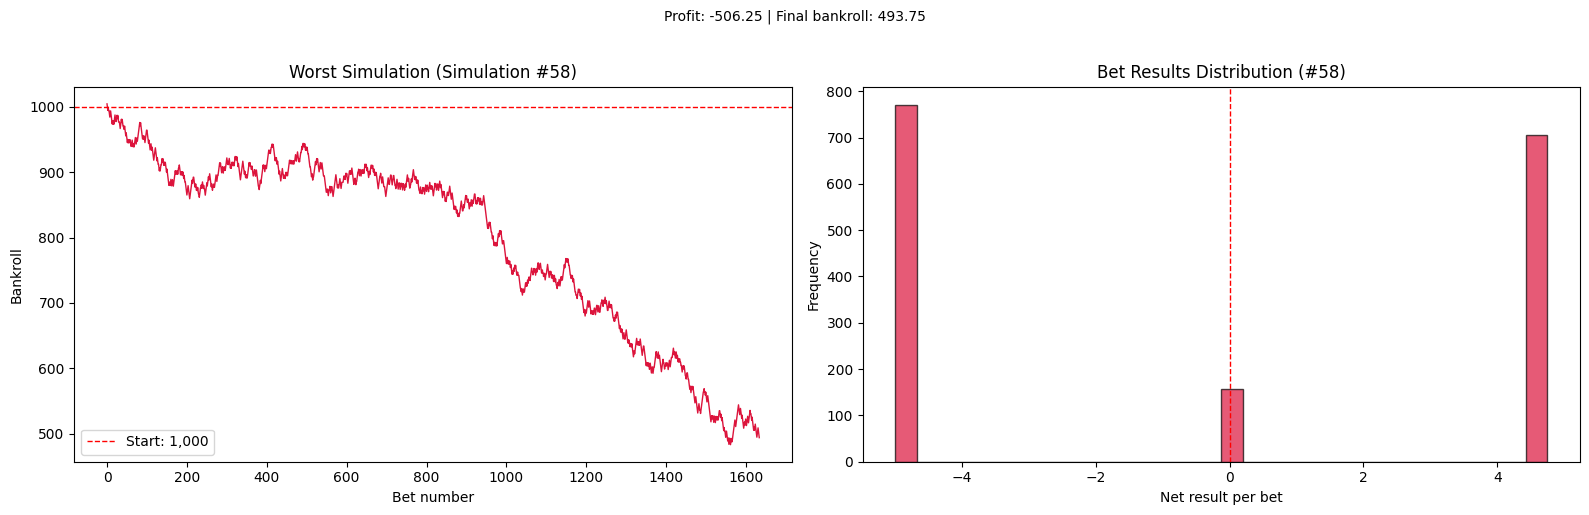

In [49]:
plot_simulation(simulations[worst_idx], worst_idx, "Worst Simulation", "crimson")

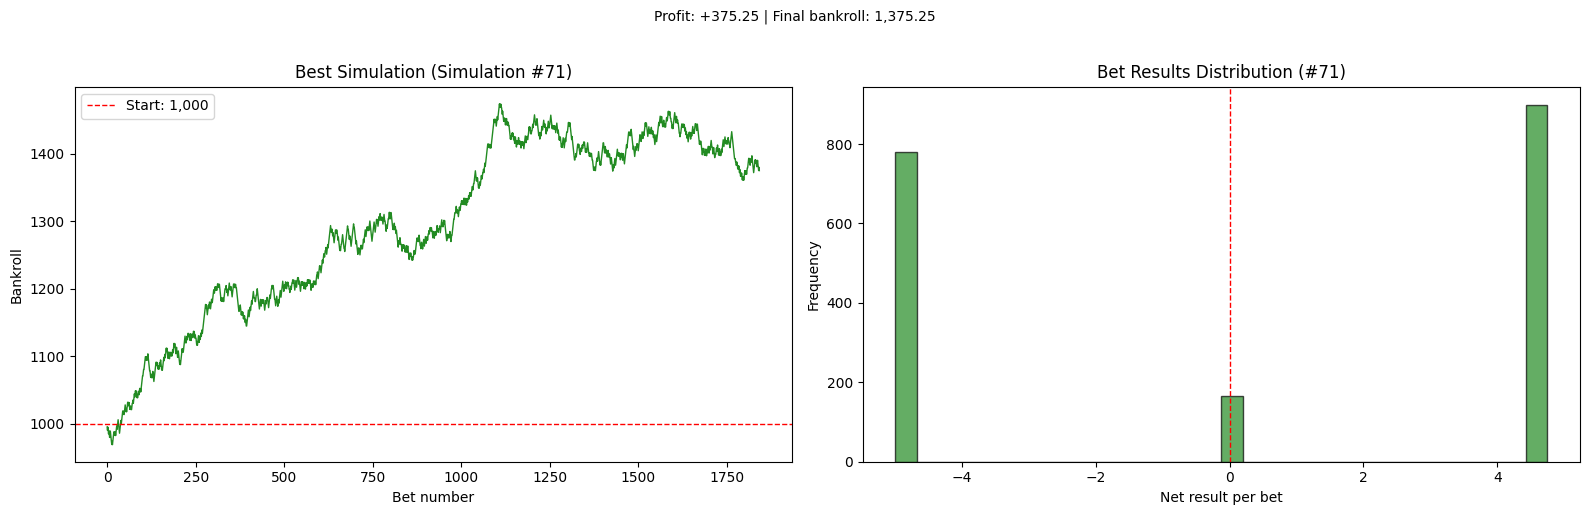

In [50]:
plot_simulation(simulations[best_idx], best_idx, "Best Simulation", "forestgreen")

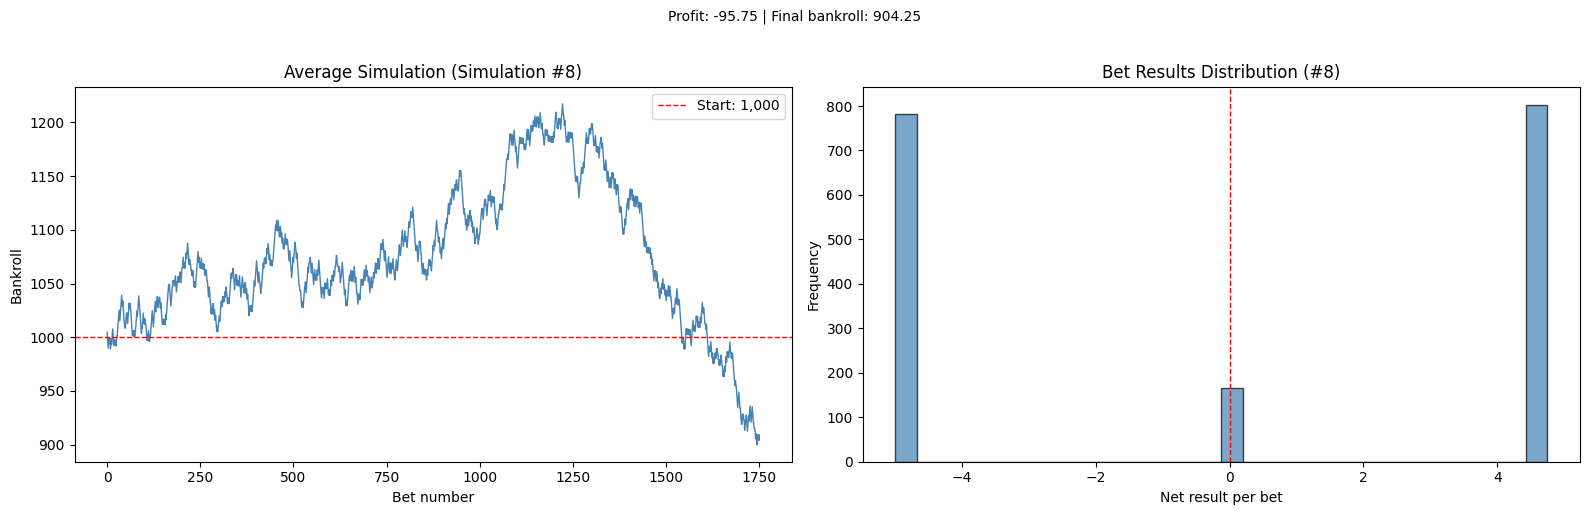

In [51]:
plot_simulation(simulations[avg_idx], avg_idx, "Average Simulation", "steelblue")

## 5. Specific Simulation View

In [ ]:
spec_sim = simulations[ESPECIF_SIMULATION_VIEW]
spec_final = get_final_bankroll(spec_sim)
spec_profit = spec_final - start_bankroll
spec_curve = extract_bankroll_curve(spec_sim)

total_bets = sum(len(a["bets"]) for a in spec_sim if a["type"] == "play")
total_sessions = sum(1 for a in spec_sim if a["type"] == "play")

# Summary table
profit_cls = "pos" if spec_profit >= 0 else "neg"
summary_rows = ""
for label, value in [
    ("Starting bankroll", f"{start_bankroll:,.2f}"),
    ("Final bankroll", f"{spec_final:,.2f}"),
    ("Profit", f'<span class="{profit_cls}">{spec_profit:+,.2f}</span>'),
    ("Total sessions", f"{total_sessions:,}"),
    ("Total bets", f"{total_bets:,}"),
    ("Min bankroll", f"{min(spec_curve):,.2f}" if spec_curve else "N/A"),
    ("Max bankroll", f"{max(spec_curve):,.2f}" if spec_curve else "N/A"),
]:
    summary_rows += f'<tr><td style="font-weight:500;">{label}</td><td style="text-align:right;">{value}</td></tr>'

# Actions table
action_rows = ""
type_badges = {
    "play": '<span style="background:#dbeafe; color:#1e40af; padding:2px 8px; border-radius:12px; font-size:11px; font-weight:600;">Play</span>',
    "withdraw": '<span style="background:#ffe4e6; color:#9f1239; padding:2px 8px; border-radius:12px; font-size:11px; font-weight:600;">Withdraw</span>',
    "aport": '<span style="background:#d1fae5; color:#065f46; padding:2px 8px; border-radius:12px; font-size:11px; font-weight:600;">Deposit</span>',
}
for i, action in enumerate(spec_sim):
    badge = type_badges.get(action["type"], action["type"])
    if action["type"] == "play":
        n_bets = len(action["bets"])
        action_rows += (
            f'<tr>'
            f'<td style="text-align:center; color:#94a3b8;">{i+1}</td>'
            f'<td>{badge}</td>'
            f'<td>{action["name"]}</td>'
            f'<td style="text-align:right;">{n_bets}</td>'
            f'<td style="text-align:right;">{action["bankroll"]:,.2f}</td>'
            f'</tr>'
        )
    elif action["type"] == "withdraw":
        action_rows += (
            f'<tr>'
            f'<td style="text-align:center; color:#94a3b8;">{i+1}</td>'
            f'<td>{badge}</td>'
            f'<td style="color:#94a3b8;">—</td>'
            f'<td style="text-align:right;">{action["size"]:,.2f}</td>'
            f'<td style="text-align:right;">{action["bankroll"]:,.2f}</td>'
            f'</tr>'
        )
    elif action["type"] == "aport":
        action_rows += (
            f'<tr>'
            f'<td style="text-align:center; color:#94a3b8;">{i+1}</td>'
            f'<td>{badge}</td>'
            f'<td style="color:#94a3b8;">—</td>'
            f'<td style="text-align:right;">{action["size"]:,.2f}</td>'
            f'<td style="text-align:right;">{action["bankroll"]:,.2f}</td>'
            f'</tr>'
        )

HTML(TABLE_CSS + f"""
<div style="font-family:-apple-system,BlinkMacSystemFont,'Segoe UI',Roboto,sans-serif; font-size:16px; font-weight:700; color:#1e293b; margin-bottom:10px;">
    Simulation #{ESPECIF_SIMULATION_VIEW}
</div>
<table class="modern-table" style="margin-bottom:16px; min-width:340px;">
<thead><tr><th colspan="2">Overview</th></tr></thead>
<tbody>{summary_rows}</tbody>
</table>

<table class="modern-table">
<thead>
  <tr>
    <th style="text-align:center; width:40px;">#</th>
    <th style="text-align:left;">Action</th>
    <th style="text-align:left;">Session</th>
    <th style="text-align:right;">Bets / Size</th>
    <th style="text-align:right;">Bankroll</th>
  </tr>
</thead>
<tbody>{action_rows}</tbody>
</table>
""")

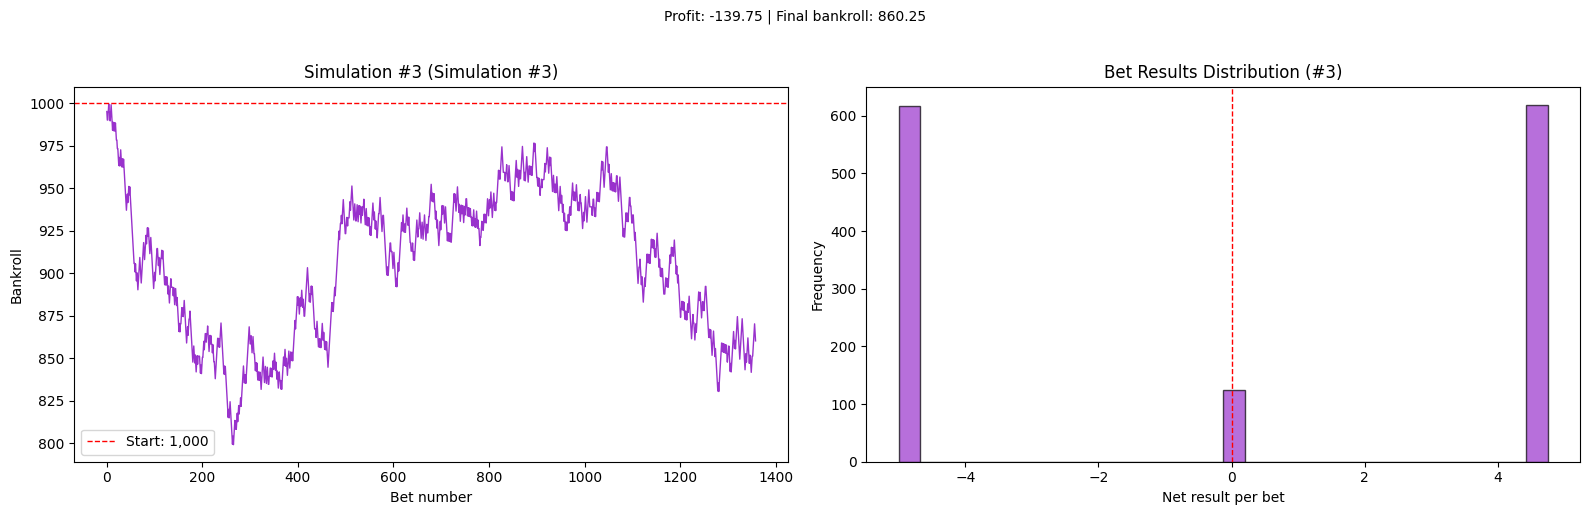

In [53]:
plot_simulation(spec_sim, ESPECIF_SIMULATION_VIEW, f"Simulation #{ESPECIF_SIMULATION_VIEW}", "darkorchid")

## 6. Risk Profile — Percentage Outcomes

In [ ]:
# Compute percentage change for each simulation
profit_pcts = [(p / start_bankroll) * 100 for p in profits]
profit_pcts_sorted = sorted(profit_pcts)

# --- Percentile summary ---
percentiles = [5, 10, 25, 50, 75, 90, 95]

rows = ""
for pct in percentiles:
    idx = int(len(profit_pcts_sorted) * pct / 100)
    idx = min(idx, len(profit_pcts_sorted) - 1)
    val = profit_pcts_sorted[idx]
    cls = "pos" if val >= 0 else "neg"
    # Progress-bar style background fill
    bar_width = min(abs(val), 60)
    bar_color = "#d1fae5" if val >= 0 else "#ffe4e6"
    rows += (
        f'<tr>'
        f'<td style="text-align:center; font-weight:700; color:#6366f1;">{pct}th</td>'
        f'<td style="text-align:right; position:relative;">'
        f'<div style="position:absolute; top:0; {"left" if val >= 0 else "right"}:0; height:100%; width:{bar_width}%; background:{bar_color}; border-radius:4px; z-index:0;"></div>'
        f'<span class="{cls}" style="position:relative; z-index:1;">{val:+.1f}%</span>'
        f'</td>'
        f'</tr>'
    )

HTML(TABLE_CSS + f"""
<table class="modern-table" style="min-width:320px;">
<thead>
  <tr><th colspan="2">Risk Percentiles — {TOTAL_SIMULATIONS:,} simulations</th></tr>
  <tr style="background:#334155;">
    <th style="background:#334155; text-align:center; padding:6px 16px; color:#cbd5e1; font-weight:500; font-size:12px;">Percentile</th>
    <th style="background:#334155; text-align:right; padding:6px 16px; color:#cbd5e1; font-weight:500; font-size:12px;">Bankroll Change</th>
  </tr>
</thead>
<tbody>{rows}</tbody>
</table>
""")

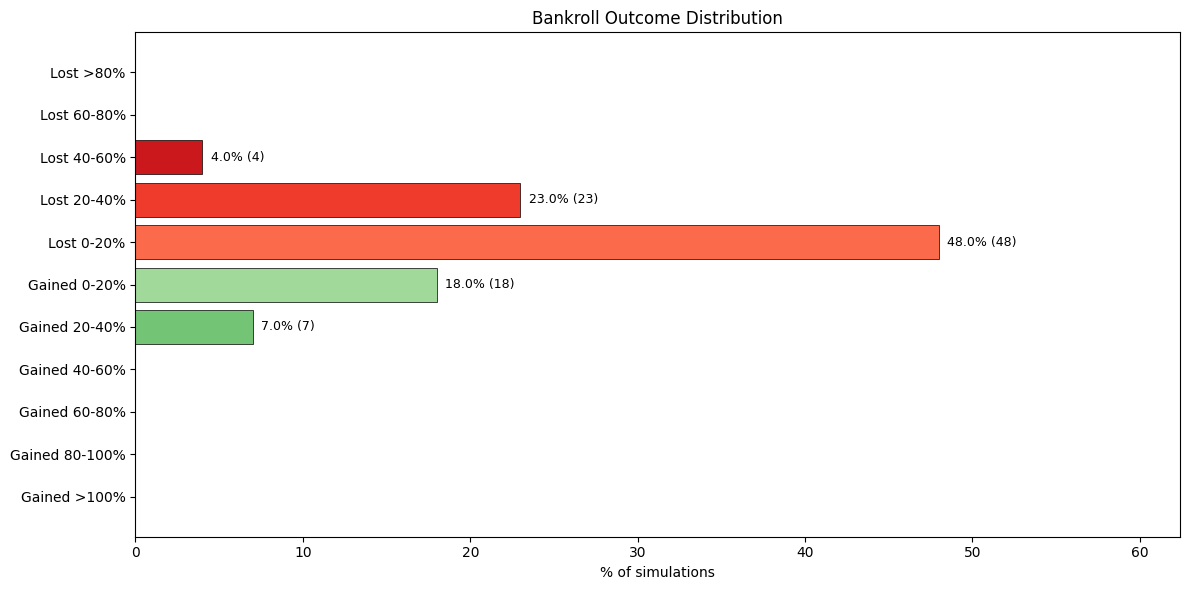

In [55]:
# --- Outcome bucket bar chart ---
# Define percentage buckets from worst to best
bucket_edges = [-float("inf"), -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, float("inf")]
bucket_labels = [
    "Lost >80%", "Lost 60-80%", "Lost 40-60%", "Lost 20-40%", "Lost 0-20%",
    "Gained 0-20%", "Gained 20-40%", "Gained 40-60%", "Gained 60-80%",
    "Gained 80-100%", "Gained >100%",
]
bucket_colors = [
    "#67000d", "#a50f15", "#cb181d", "#ef3b2c", "#fb6a4a",
    "#a1d99b", "#74c476", "#41ab5d", "#238b45", "#006d2c", "#00441b",
]

bucket_counts = [0] * len(bucket_labels)
for pct in profit_pcts:
    for i in range(len(bucket_edges) - 1):
        if bucket_edges[i] <= pct < bucket_edges[i + 1]:
            bucket_counts[i] += 1
            break

bucket_pcts = [c / TOTAL_SIMULATIONS * 100 for c in bucket_counts]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(bucket_labels, bucket_pcts, color=bucket_colors, edgecolor="black", linewidth=0.5)

for bar, pct_val, count in zip(bars, bucket_pcts, bucket_counts):
    if pct_val > 0:
        ax.text(
            bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
            f"{pct_val:.1f}% ({count})",
            va="center", fontsize=9,
        )

ax.set_xlabel("% of simulations")
ax.set_title("Bankroll Outcome Distribution")
ax.set_xlim(0, max(bucket_pcts) * 1.3)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

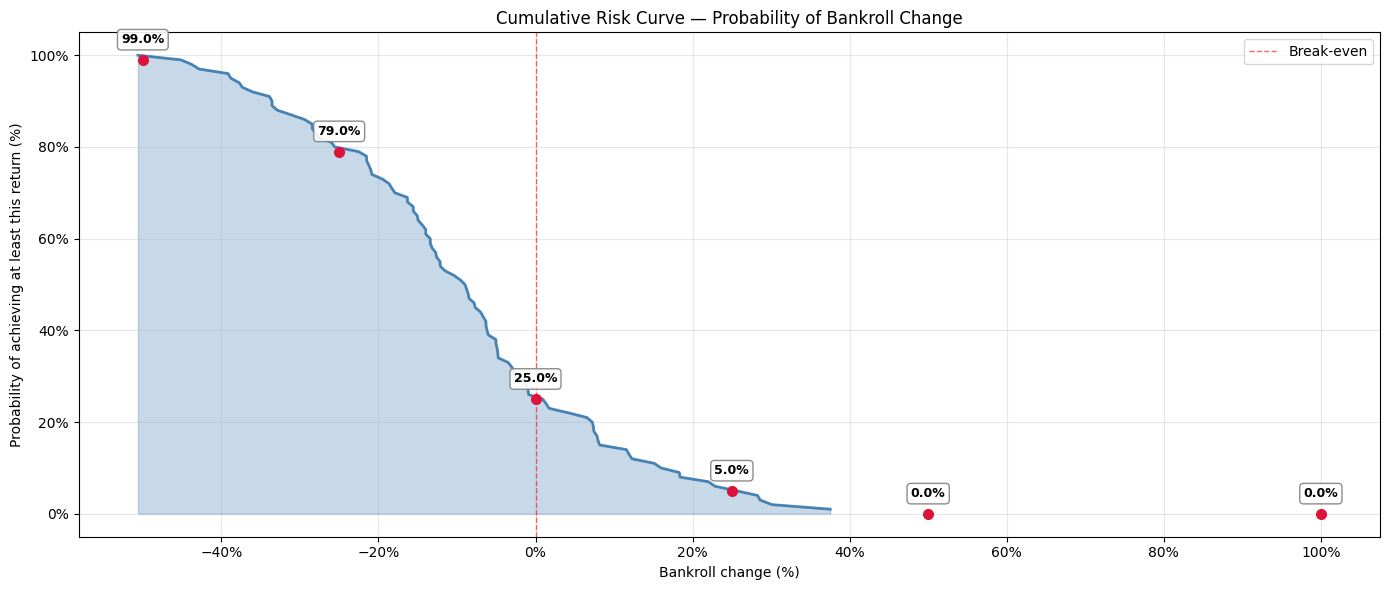

In [56]:
# --- Cumulative probability curve ---
# "What is the probability of achieving at least X% return?"
fig, ax = plt.subplots(figsize=(14, 6))

# Survival function: P(profit% >= x)
x_vals = profit_pcts_sorted
y_vals = [(TOTAL_SIMULATIONS - i) / TOTAL_SIMULATIONS * 100 for i in range(TOTAL_SIMULATIONS)]

ax.fill_between(x_vals, y_vals, alpha=0.3, color="steelblue")
ax.plot(x_vals, y_vals, color="steelblue", linewidth=2)

# Mark key thresholds
thresholds = [-50, -25, 0, 25, 50, 100]
for t in thresholds:
    prob = sum(1 for p in profit_pcts if p >= t) / TOTAL_SIMULATIONS * 100
    ax.plot(t, prob, "o", color="crimson", markersize=7, zorder=5)
    ax.annotate(
        f"{prob:.1f}%",
        xy=(t, prob), xytext=(0, 12),
        textcoords="offset points", ha="center", fontsize=9, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.9),
    )

ax.axvline(0, color="red", linestyle="--", linewidth=1, alpha=0.6, label="Break-even")
ax.set_xlabel("Bankroll change (%)")
ax.set_ylabel("Probability of achieving at least this return (%)")
ax.set_title("Cumulative Risk Curve — Probability of Bankroll Change")
ax.legend()
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(mticker.PercentFormatter())
ax.xaxis.set_major_formatter(mticker.PercentFormatter())
plt.tight_layout()
plt.show()

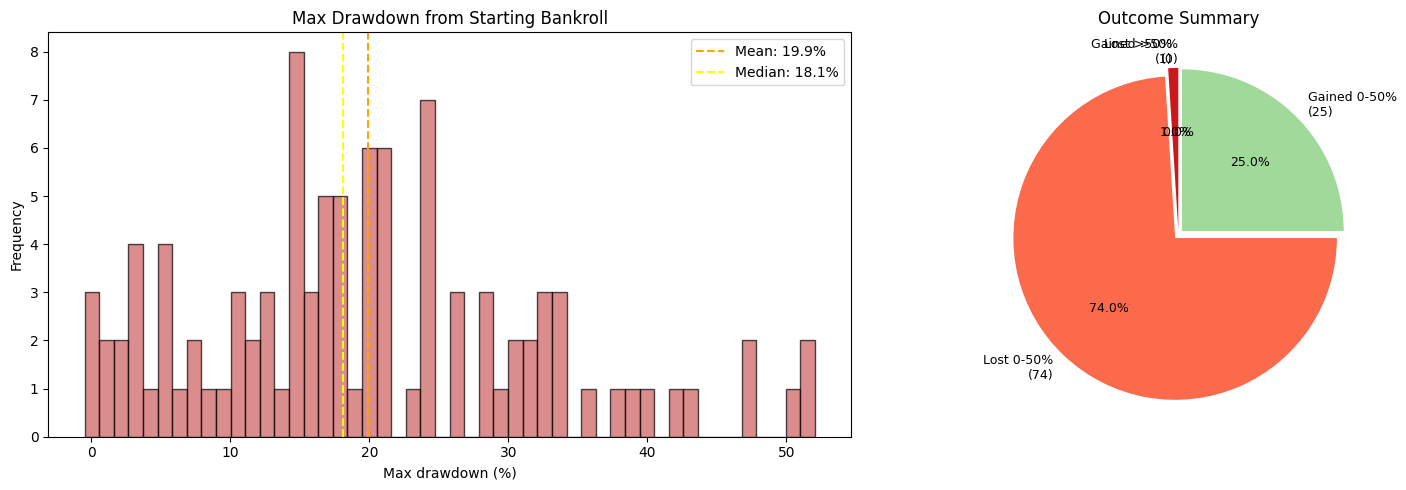

In [57]:
# --- Max drawdown distribution ---
# For each simulation, compute the worst drop from the starting bankroll
max_drawdowns_pct = [((start_bankroll - mb) / start_bankroll) * 100 for mb in min_bankrolls]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: histogram of max drawdowns
axes[0].hist(max_drawdowns_pct, bins=50, edgecolor="black", alpha=0.7, color="indianred")
axes[0].axvline(
    statistics.mean(max_drawdowns_pct), color="orange", linestyle="--", linewidth=1.5,
    label=f"Mean: {statistics.mean(max_drawdowns_pct):.1f}%",
)
axes[0].axvline(
    statistics.median(max_drawdowns_pct), color="yellow", linestyle="--", linewidth=1.5,
    label=f"Median: {statistics.median(max_drawdowns_pct):.1f}%",
)
axes[0].set_title("Max Drawdown from Starting Bankroll")
axes[0].set_xlabel("Max drawdown (%)")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Right: pie chart of gain vs loss vs heavy loss
heavy_loss = sum(1 for p in profit_pcts if p <= -50)
mild_loss = sum(1 for p in profit_pcts if -50 < p < 0)
mild_gain = sum(1 for p in profit_pcts if 0 <= p < 50)
heavy_gain = sum(1 for p in profit_pcts if p >= 50)

pie_labels = [
    f"Lost >50%\n({heavy_loss})",
    f"Lost 0-50%\n({mild_loss})",
    f"Gained 0-50%\n({mild_gain})",
    f"Gained >50%\n({heavy_gain})",
]
pie_sizes = [heavy_loss, mild_loss, mild_gain, heavy_gain]
pie_colors = ["#cb181d", "#fb6a4a", "#a1d99b", "#238b45"]
pie_explode = (0.03, 0.03, 0.03, 0.03)

axes[1].pie(
    pie_sizes, labels=pie_labels, colors=pie_colors, explode=pie_explode,
    autopct="%1.1f%%", startangle=90, textprops={"fontsize": 9},
)
axes[1].set_title("Outcome Summary")

plt.tight_layout()
plt.show()